In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [2]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [3]:
from pandas import read_csv, DataFrame

training_data = np.load(DATA_DIR/'training_data.npy')
test_data = np.load(DATA_DIR/'test_data.npy')
training_label = np.load(DATA_DIR/'training_label.npy')
test_label = np.load(DATA_DIR/'test_label.npy')

In [4]:
import dill
import json

with open(DATA_DIR/'sv_storage', 'rb') as fp:
    sv_storage = dill.load(fp)

with open(DATA_DIR/'qasm_storage', 'rb') as fp:
    qasm_storage = dill.load(fp)

with open(DATA_DIR/'sv_qasvm', 'rb') as fp:
    sv_qasvm = dill.load(fp)

with open(DATA_DIR/'qasm_qasvm', 'rb') as fp:
    qasm_qasvm = dill.load(fp)

sv_fvec = np.load(DATA_DIR/'sv_fvec.npy')
qasm_fvec = np.load(DATA_DIR/'qasm_fvec.npy')

In [49]:
print(sum(np.where(sv_fvec>0, 1, 0)==test_label)/len(test_label))
print(sum(np.where(qasm_fvec>0, 1, 0)==test_label)/len(test_label))

0.9534883720930233
0.9418604651162791


In [18]:
from qiskit.quantum_info import Statevector
from classifiers.quantum.ansatz import Circuit15
var_form = Circuit15(num_qubits=6, reps=5)
Statevector(var_form.assign_parameters(np.array(sv_qasvm.parameters))).probabilities()

array([2.42422357e-03, 9.39563256e-03, 4.43242959e-04, 3.29580787e-05,
       3.13650577e-03, 6.11611373e-05, 1.25952780e-02, 3.39150437e-02,
       7.49229849e-03, 7.46319226e-02, 4.21075060e-02, 4.95193694e-02,
       3.07751835e-04, 1.70807458e-02, 2.59246932e-03, 2.49311117e-02,
       6.59620367e-03, 3.11266938e-03, 4.67432953e-04, 4.23954912e-02,
       2.26494190e-04, 1.09658861e-03, 6.22309039e-05, 3.78866074e-03,
       3.81585361e-02, 3.97093323e-03, 8.84686746e-02, 6.31363119e-05,
       2.20731142e-03, 1.16378639e-02, 3.82038286e-04, 1.74019352e-04,
       5.16397642e-04, 3.04179653e-05, 9.12472761e-03, 6.35184252e-05,
       2.95336331e-03, 4.71266159e-03, 1.66936148e-04, 1.55974887e-04,
       2.41022582e-05, 1.53809013e-01, 6.36012407e-06, 7.66978511e-03,
       1.33637769e-03, 1.18519847e-02, 3.97295106e-02, 5.29299876e-03,
       6.23192415e-05, 8.22405801e-02, 2.07913553e-03, 6.08057280e-06,
       9.15895081e-03, 3.91834178e-04, 3.87883363e-05, 3.50218356e-03,
      

In [5]:
from classifiers.convex.svm import CvxSoftQASVM

training_kernel = sv_qasvm.kernel_matrix
#test_kernel = sv_qasvm._qk.evaluate(test_data, training_data)

svm = CvxSoftQASVM(kernel='precomputed', C=10**4, lamda=10**4)
svm.fit(training_kernel, training_label)
#true_f = svm.f(test_kernel)

array([1.75821689e-09, 6.18922063e-03, 2.34147463e-09, 3.91199508e-09,
       6.88306450e-09, 6.99848284e-09, 1.42449206e-02, 1.01390471e-02,
       3.56614330e-09, 1.22035829e-01, 3.42506283e-02, 4.12919141e-02,
       9.62599794e-07, 3.25291379e-02, 1.67960512e-09, 9.25288494e-03,
       4.60849326e-09, 1.94113167e-09, 1.72728618e-09, 7.63653481e-02,
       8.14429185e-09, 2.07414406e-02, 1.77869107e-09, 1.82034482e-09,
       3.32441754e-09, 3.13701656e-09, 8.54585929e-02, 2.65831880e-08,
       3.48803853e-02, 1.97748950e-02, 3.27063685e-09, 1.95886079e-06,
       1.33940922e-08, 5.30229288e-09, 1.28278075e-08, 1.49516897e-08,
       4.90862405e-09, 2.57395288e-09, 8.44084545e-09, 1.24279116e-07,
       2.65168121e-09, 1.56047524e-01, 2.38947710e-02, 3.36007764e-09,
       9.24538097e-09, 8.42314587e-09, 3.74732583e-02, 3.78144834e-09,
       5.59470187e-09, 7.96502704e-02, 9.35018971e-08, 3.51864071e-09,
       2.39524747e-09, 2.56792501e-09, 5.69418974e-09, 1.84840317e-08,
      

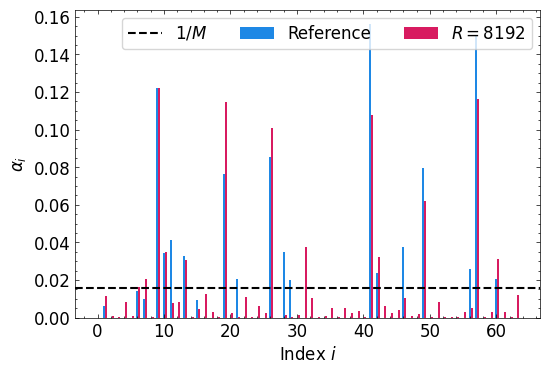

In [55]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))
var_form = Circuit15(num_qubits=6, reps=5)
qasm_alpha = Statevector(var_form.assign_parameters(np.array(qasm_qasvm.parameters))).probabilities()
sv_alpha = Statevector(var_form.assign_parameters(np.array(sv_qasvm.parameters))).probabilities()
true_alpha = np.array(svm.alpha)

with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    xbar = np.arange(len(qasm_alpha))
    ax.bar(xbar, true_alpha, width=0.3, color=colors[1], label='Reference')
    ax.bar(xbar+0.3, qasm_alpha, width=0.3, color=colors[0], label=r'$R=8192$')
    # ax.bar(xbar-0.25, sv_alpha, width=0.25, color=colors[1], label=r'$R=\infty$')
    ax.axhline(1/len(true_alpha), color='k', linestyle='--', label=r'$1/M$')
    ax.set_xlabel(r'Index $i$')
    ax.set_ylabel(r'$\alpha_i$')
    ax.legend(ncol=3)
fig.savefig('./figs/numerical_analysis_alpha.png', dpi=300)
fig.savefig('./figs/numerical_analysis_alpha.svg', dpi=300)
fig.savefig('./figs/numerical_analysis_alpha.pdf', dpi=300)
fig

/home/quic/QUIC-Projects/classifiers/callback.py:114: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return df['Cost'][-last:].mean()
/home/quic/QUIC-Projects/classifiers/callback.py:121: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return df['Cost'][-last:].std()


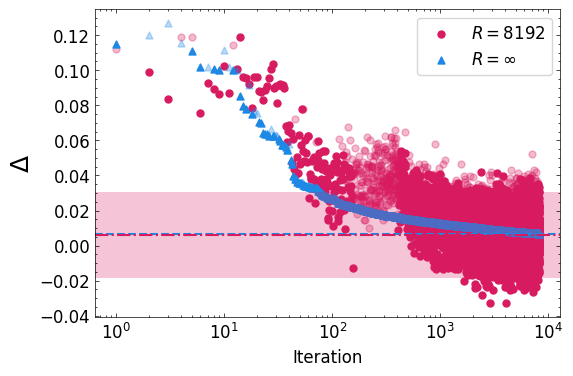

In [33]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    ax.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='o', c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    #ax.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color1, label='QASVM')
    ax.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost']-svm.dual_objective_value, marker='o', alpha=0.3, c=colors[0])
    ax.scatter(df2.loc[df2['Accepted']==True]['Step'], df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='^', c=colors[1], label=r'$R=\infty$')
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    ax.scatter(df2.loc[df2['Accepted']==False]['Step'], df2.loc[df2['Accepted']==False]['Cost']-svm.dual_objective_value, marker='^', alpha=0.3, c=colors[1])
    ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    ax.axhspan(ymin=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value-2*qasm_storage.last_cost_std(16, ignore_rejected=True),
                ymax=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value+2*qasm_storage.last_cost_std(16, ignore_rejected=True),
                xmin=0, xmax=1, facecolor=colors[0], alpha=0.25)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$\Delta$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

fig.savefig('./figs/numerical_analysis_shot_noise.png', dpi=300)
fig.savefig('./figs/numerical_analysis_shot_noise.svg', dpi=300)
fig.savefig('./figs/numerical_analysis_shot_noise.pdf', dpi=300)
fig

In [284]:
qasm_fvec_list = []
from tqdm import tqdm

for _ in tqdm(range(10)):
    qasm_fvec_list.append(qasm_qasvm.f(test_data))

result_list = []
for _fvec in qasm_fvec_list:
    result_list.append(np.mean(np.abs(_fvec-true_f)))

print(np.mean(result_list), np.std(result_list))

100%|██████████| 10/10 [06:28<00:00, 38.85s/it]

0.011888029523506038 0.0008024745055903194


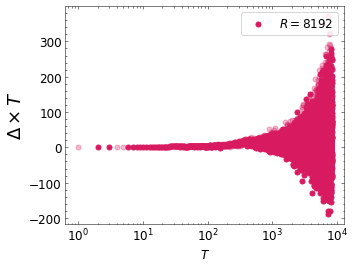

In [295]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))

df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(5, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    steps = df1.loc[df1['Accepted']==True]['Step']
    delta = df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value
    steps_ = df1.loc[df1['Accepted']==False]['Step']
    delta_ = df1.loc[df1['Accepted']==False]['Cost']-svm.dual_objective_value

    ax.scatter(steps, steps*delta, marker='o', c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    #ax.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color1, label='QASVM')
    ax.scatter(steps_, steps_*delta_, marker='o', alpha=0.3, c=colors[0])

    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(r'$\Delta\times T$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

# fig.savefig('./figs/numerical_analysis_shot_noise.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_shot_noise.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_shot_noise.pdf', dpi=300)

In [296]:
def coarse_grain(x, y, d, acc=None):
    x = np.log10(x)
    new_x = []
    new_y = []
    min_x = min(x)
    max_x = max(x)
    is_acc = []

    for i, _x in enumerate(x):
        if (_x>min_x+d) & (_x<max_x-d):
            _ind = (x<_x+d) * (x>_x-d)
            new_x.append(_x)
            if sum(_ind):
                new_y.append(np.sum(y[_ind])/np.sum(_ind))
            else:
                new_y.append(y[i])
            if acc is not None:
                is_acc.append(acc[i])
    if acc is not None:
        return 10**np.array(new_x), np.array(new_y), np.array(is_acc)
    else:
        return 10**np.array(new_x), np.array(new_y)


In [297]:
steps = df1['Step']
delta = df1['Cost']-svm.dual_objective_value
accval = df1["Accepted"]

new_steps, new_delta, new_accval = coarse_grain(steps[10:], np.array(delta[10:]), 0.1, accval)

steps_ = df2['Step']
delta_ = df2['Cost']-svm.dual_objective_value
accval_ = df2["Accepted"]

new_steps_, new_delta_, new_accval_ = coarse_grain(steps_[10:], np.array(delta_[10:]), 0.1, accval_)

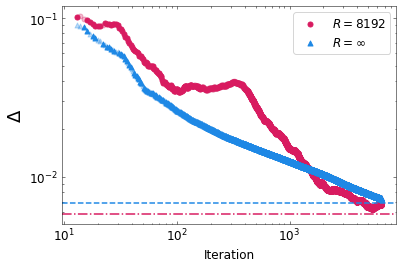

In [299]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    ax.scatter(new_steps[new_accval], new_delta[new_accval], c=colors[0], marker='o', label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    ax.scatter(new_steps[~new_accval], new_delta[~new_accval], c=colors[0], marker='o', alpha=0.3)
    ax.scatter(new_steps_[new_accval_], new_delta_[new_accval_], c=colors[1], marker='^', label=r'$R=\infty$')
    ax.scatter(new_steps_[~new_accval_], new_delta_[~new_accval_], c=colors[1], marker='^', alpha=0.3)
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    #ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    #ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    # ax.axhspan(ymin=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value-2*qasm_storage.last_cost_std(16, ignore_rejected=True),
    #         ymax=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value+2*qasm_storage.last_cost_std(16, ignore_rejected=True),
    #         xmin=0, xmax=1, facecolor=colors[0], alpha=0.25)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$\Delta$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

fig.savefig('./figs/numerical_analysis_no_shot_noise.png', dpi=300)
fig.savefig('./figs/numerical_analysis_no_shot_noise.svg', dpi=300)
fig.savefig('./figs/numerical_analysis_no_shot_noise.pdf', dpi=300)

In [289]:
def coarse_grain2(x, y, d):
    new_x = []
    new_y = []
    min_x = min(x)
    max_x = max(x)

    for i, _x in enumerate(x):
        if (_x>min_x+d) & (_x<max_x-d):
            _ind = (x<_x+d) * (x>_x-d)
            new_x.append(_x)
            if sum(_ind):
                new_y.append(np.sum(y[_ind])/np.sum(_ind))
            else:
                new_y.append(y[i])
    return np.array(new_x), np.array(new_y)

In [290]:
steps = df1['Step']
delta = df1['Cost']-svm.dual_objective_value

new_steps, new_delta = coarse_grain2(steps, np.array(delta), 64)

steps_ = df2['Step']
delta_ = df2['Cost']-svm.dual_objective_value

new_steps_, new_delta_ = coarse_grain2(steps_, np.array(delta_), 64)

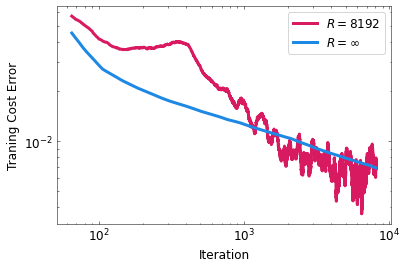

In [291]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.linewidth':3}):
    fig, ax = plt.subplots()
    ax.plot(new_steps, new_delta, c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    ax.plot(new_steps_, new_delta_, c=colors[1], label=r'$R=\infty$')
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    #ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    #ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Traning Cost Error')
    ax.legend(loc='upper right')

# fig.savefig('./figs/numerical_analysis_no_shot_noise.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_no_shot_noise.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_no_shot_noise.pdf', dpi=300)